In [97]:
import os
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from keras import layers
import matplotlib.pyplot as plt
from keras import regularizers
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from wordcloud import WordCloud
from keras.models import Sequential
from keras.utils import to_categorical
from keras.utils import pad_sequences
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [98]:
import warnings
warnings.filterwarnings("ignore")

In [99]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [100]:
!mv kaggle.json ~/.kaggle/

mv: cannot stat 'kaggle.json': No such file or directory


In [101]:
import kaggle

In [102]:
!chmod 600 /root/.kaggle/kaggle.json

In [103]:
!kaggle datasets download -d snap/amazon-fine-food-reviews

amazon-fine-food-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [104]:
!unzip -q /content/amazon-fine-food-reviews.zip

replace Reviews.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [105]:
df = pd.read_csv("/content/Reviews.csv")

In [106]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [107]:
df.shape

(568454, 10)

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [109]:
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [110]:
df.isna().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [111]:
df.dropna(inplace=True)

## EDA

Plot of Number of Review scores

In [112]:
df1 =df.copy()

In [113]:
df1[df1['HelpfulnessNumerator'] > df1['HelpfulnessDenominator']].shape

(2, 10)

Found invalid data entries as values exceed denominator values

In [114]:
df1 = df1[df1['HelpfulnessNumerator'] <= df1['HelpfulnessDenominator']]

In [115]:
df1.ProductId.nunique()

74258

Found duplicates of products with repeating ProductId. Taking only one review per user each product

In [116]:
sorted_data=df1.sort_values('ProductId', axis=0, ascending=True, kind='quicksort')

In [117]:
df1 = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, inplace=False)

In [118]:
df1.shape

(393917, 10)

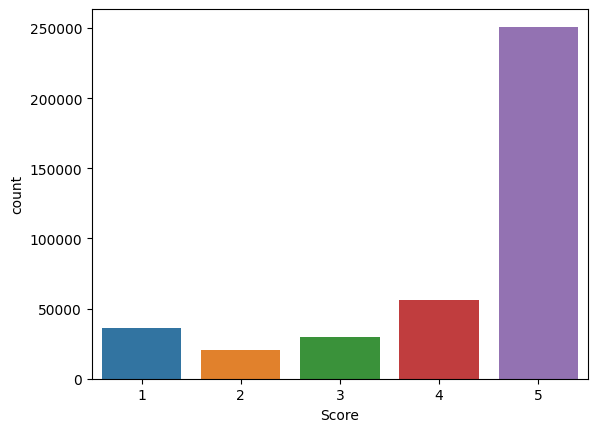

In [119]:
sns.countplot(x=df1.Score)
plt.show()

Categorizing the sentiments into 2 groups:<br>
1. Positive
2. Negative

In [120]:
def score_split(score):
  if(score > 3):
    return 'Positive'
  elif(score <= 3):
    return 'Negative'


In [121]:
df1['score_split']= df1['Score'].apply(score_split)

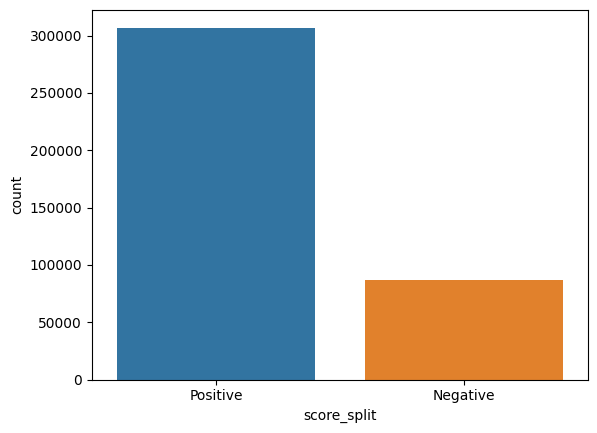

In [122]:
sns.countplot(x=df1.score_split)
plt.show()

In [123]:
nltk.download('stopwords')
nltk.download('punkt')

def remove_stopwords(ss,sw=  set(stopwords.words('english')),stem='Stem'):
  s =list(sw) + ['hi', 'im', 'i']
  sw =set(s)
  translator = str.maketrans('', '', string.punctuation)
  ss = ss.translate(translator)
  text = ss.split()
  text_filtered = [word for word in text if not word in sw]
  text_filtered = [re.sub(r'\w*\d\w*', '', w) for w in text_filtered]
  text_filtered = [w.lower() for w in text_filtered if len(w) > 2]
  filtered_sentence=text_filtered
  return  ' '.join(filtered_sentence)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [124]:
df1['Summary_new'] = df1['Summary'].apply(remove_stopwords)

Top 10 words in each score : Positive Score

In [128]:
df1.groupby('score_split')['Summary_new'].apply(lambda x: nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(x))).most_common(10))["Positive"]

[('great', 46481),
 ('good', 29116),
 ('best', 22973),
 ('love', 16987),
 ('delicious', 13076),
 ('tea', 12736),
 ('coffee', 12545),
 ('product', 11445),
 ('the', 9578),
 ('excellent', 9147)]

In [134]:
plist =""
for i in df1[df1['score_split'] == 'Positive']['Summary_new']:
  plist = plist + i +' '

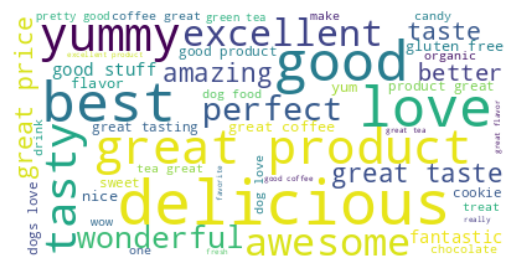

In [ ]:
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(plist)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Top 10 words in each score : Negative Score

In [129]:
nlist = df1.groupby('score_split')['Summary_new'].apply(lambda x: nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(x))).most_common(10))["Negative"]
nlist

[('not', 9817),
 ('good', 6426),
 ('taste', 4137),
 ('like', 3400),
 ('great', 3179),
 ('product', 2677),
 ('flavor', 2394),
 ('bad', 2367),
 ('coffee', 2150),
 ('dont', 1666)]

In [136]:
nlist =""
for i in df1[df1['score_split'] == 'Negative']['Summary_new']:
  nlist = nlist + i +' '

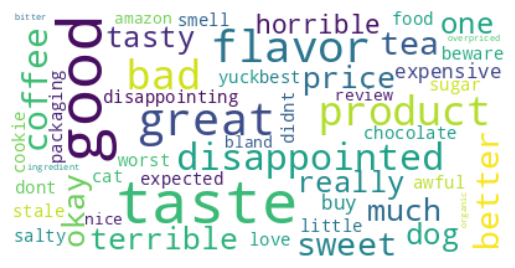

In [ ]:
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(nlist)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Number of Reviews rated by  users

In [31]:
print(df1[df1.HelpfulnessDenominator != 0].shape[0], "out of ",df1.shape[0],"rated reviews - {:.2f} %".format(df1[df1.HelpfulnessDenominator != 0].shape[0]/df1.shape[0] * 100))

209307 out of  393917 rated reviews - 53.13 %


Split of Helpfulness of the reviews rated. Here total 209307 review are rated.

In [32]:
df2 = df1[df1['HelpfulnessDenominator']!=0].copy()
df2['helpfullness']= df2['HelpfulnessNumerator'] / df2['HelpfulnessDenominator']

In [33]:
def help_checker(x):
  if x >= 0.75:
    return '> 75%'
  elif x ==0:
    return 'No Rating'
  elif x < 0.25:
    return '< 25%'
  else:
    return '25 -75%'

In [34]:
h=df2['helpfullness'].apply(help_checker).value_counts()

In [35]:
df_help = pd.DataFrame()
df_help['Percentage_of_Helpness'] = h.keys()
df_help['No_of_reviews']= h.values

<Axes: xlabel='Percentage_of_Helpness', ylabel='No_of_reviews'>

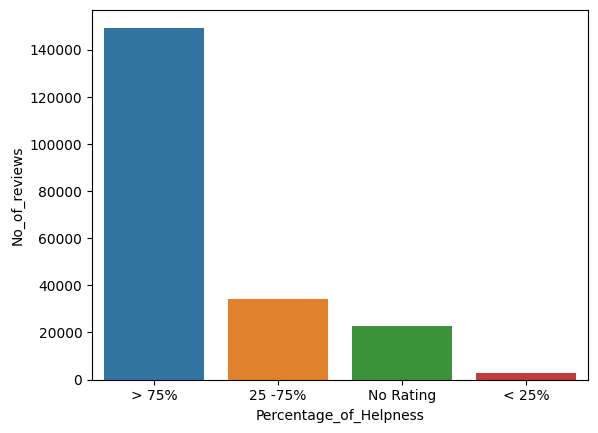

In [36]:
sns.barplot(x=df_help['Percentage_of_Helpness'],y=df_help['No_of_reviews'])

Highest and lowest rating for the products. Percentage wise product ratings for the entire data.


In [37]:
df1['Score_percentage']=df.Score/5 *100

In [38]:
df1.groupby('ProductId')['Score','Score_percentage'].agg({'Score':['min','max'],'Score_percentage':'mean'}).head(10)

Score     Score_percentage
             min max             mean
ProductId                            
0006641040     1   5        87.027027
141278509X     5   5       100.000000
2734888454     2   5        70.000000
2841233731     5   5       100.000000
7310172001     1   5        94.941176
7800648702     3   5        80.000000
9376674501     5   5       100.000000
B00002N8SM     1   5        35.789474
B00002NCJC     4   5        90.000000
B00002Z754     5   5       100.000000

Total number of reviews by unique profiles. How many customers or profiles have reviewed more than one product?

In [39]:
df1['user_counter'] = df.UserId.map(df["UserId"].value_counts())

In [40]:
print("Total number of reviews by unique profiles : ", df1[df1['user_counter'] == 1].shape[0], "/",df1.shape[0])

Total number of reviews by unique profiles :  175383 / 393917


In [41]:
print("Total number of customers or profiles have reviewed more than one products : ", df1[df1['user_counter'] != 1].shape[0], "/",df1.shape[0])

Total number of customers or profiles have reviewed more than one products :  218534 / 393917


Frequency of reviewers

In [42]:
df3 = df1.groupby('UserId')['ProductId'].count().reset_index(name='count').sort_values('count', ascending=False)

In [43]:
def freq_checker(x):
  if x > 50:
    return 'Frequent'
  else :
    return 'Not Frequent'

In [44]:
df3['freq_user']= df3['count'].apply(freq_checker)

In [45]:
df1["freq_user"]= df1["UserId"].map(dict(zip(df3["UserId"], df3["freq_user"])))

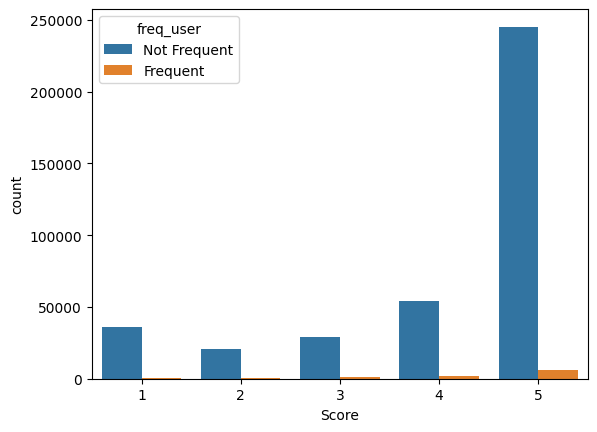

In [46]:
sns.countplot(x ='Score', hue = "freq_user", data = df1)
plt.show()

## Preprocessing

Cleaning already done before EDA.Now preprocessing

In [47]:
df1.reset_index(inplace=True)

In [48]:
df1.shape

(393917, 16)

In [49]:
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [50]:
def htmltagclean(sen):
  return (re.sub('<.*?>','',sen)).strip()

def punclean(sen):
  cleaned =  re.sub(r'[? | ! | \' | "| # | -]',' ',sen)
  return (re.sub(r'[. | , | ) | ( | \ |/ | < | >]',' ',cleaned)).strip()

def decontracted(sen):
    phrase = re.sub(r"won't", "will not", sen)
    phrase = re.sub(r"http\S+", '', phrase)
    phrase = re.sub(r"can't", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [51]:
pp_rev=list()
pp_sen=list()
for sentence in tqdm(df1.Text.values):
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = htmltagclean(punclean(decontracted(sentence)))
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    pp_sen.append(sentence)
    pp_rev.append(sentence.strip())

100%|██████████| 393917/393917 [03:37<00:00, 1813.82it/s]


In [52]:
df1["processed_text"] = pp_rev

In [53]:
def conv_score(x):
  if x == 'Positive':
    return 1
  else:
    return 0

In [54]:
df1['score_split']=df1['score_split'].apply(conv_score)

In [55]:
xtrain, xtest, ytrain, ytest = train_test_split(df1["processed_text"], df1['score_split'], test_size = 0.2, stratify=df1['score_split'])

BAG OF WORDS

In [56]:
cv = CountVectorizer()
cv.fit(xtrain)

CountVectorizer()

In [57]:
print("Some Feature Names ", cv.get_feature_names_out()[100:110])

Some Feature Names  ['abdomen' 'abdominal' 'abduct' 'abdul' 'abdy' 'abe' 'abeautiful' 'abeja'
 'abejas' 'abel']


In [58]:
bgw_cv_train = cv.transform(xtrain)
bgw_cv_test = cv.transform(xtest)

TF-IDF

In [59]:
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tfidf.fit(xtrain)
train_tfidf = tfidf.transform(xtrain)
test_tfidf = tfidf.transform(xtest)
print("Some Feature Names ", tfidf.get_feature_names_out()[100:110])

Some Feature Names  ['able resist' 'able return' 'able run' 'able salvage' 'able sample'
 'able satisfy' 'able save' 'able say' 'able see' 'able sell']


Word2Vec

In [60]:

ls_train,ls_test=list(), list()
for s in xtrain:
  ls_train.append(s.split())
w2v_model_train=Word2Vec(ls_train,min_count = 5, vector_size=50 , workers=4)
w2v_words_train = list(w2v_model_train.wv.index_to_key)
print("Sample Words : ", w2v_words_train[0:50])

Sample Words :  ['like', 'good', 'taste', 'one', 'great', 'would', 'product', 'flavor', 'coffee', 'tea', 'love', 'get', 'really', 'food', 'much', 'amazon', 'use', 'also', 'time', 'little', 'buy', 'price', 'best', 'find', 'make', 'well', 'even', 'tried', 'better', 'try', 'chocolate', 'eat', 'sugar', 'water', 'first', 'used', 'could', 'found', 'sweet', 'made', 'bag', 'box', 'drink', 'cup', 'bought', 'dog', 'free', 'way', 'think', 'store']


In [61]:
for s in xtest:
  ls_test.append(s.split())
w2v_model_test=Word2Vec(ls_test,min_count = 5, vector_size=50 , workers=4)
w2v_words_test = list(w2v_model_test.wv.index_to_key)

## Model Building

Logistic Regression with bag of words



In [62]:
sc = StandardScaler(with_mean=False)
X_train_bow = sc.fit_transform(bgw_cv_train)
X_test_bow = sc.transform(bgw_cv_test)

C2 = 0.01
LGR1=LogisticRegression(penalty='l1',C=C2,solver='liblinear',max_iter=500)

In [63]:
LGR1.fit(X_train_bow, ytrain)
pred = LGR1.predict(X_test_bow)
accuracy_score(ytest, pred)

0.8829330828594638

In [64]:
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.79      0.64      0.71     17375
           1       0.90      0.95      0.93     61409

    accuracy                           0.88     78784
   macro avg       0.85      0.80      0.82     78784
weighted avg       0.88      0.88      0.88     78784



Logistic Regression with TF -IDF

In [65]:
X_train_tfidf = sc.fit_transform(train_tfidf)
X_test_tfidf = sc.transform(test_tfidf)

C1 =0.01
LGR1=LogisticRegression(penalty='l1',C=C1,solver='liblinear',max_iter=500)

In [66]:
LGR1.fit(X_train_tfidf, ytrain)
pred = LGR1.predict(X_test_tfidf)
accuracy_score(ytest, pred)

0.891158103168156

In [67]:
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.78      0.70      0.74     17375
           1       0.92      0.94      0.93     61409

    accuracy                           0.89     78784
   macro avg       0.85      0.82      0.84     78784
weighted avg       0.89      0.89      0.89     78784



Logistic Regression with Word2Vec

In [68]:
def avgwv(los, wvmodel,wvwords):
  list_vectors = [];
  for sent in tqdm(los):
     sent_vec = np.zeros(50)
     cnt_words =0
     for word in sent:
          if word in wvwords:
             vec = wvmodel.wv[word]
             sent_vec += vec
             cnt_words += 1
     if cnt_words != 0:
          sent_vec /= cnt_words
     list_vectors.append(sent_vec)
  vectors = np.array(list_vectors)
  print(vectors.shape)
  return (vectors)

In [69]:
train_vectors = avgwv(ls_train, w2v_model_train, w2v_words_train)
test_vectors = avgwv(ls_test, w2v_model_test, w2v_words_test)

100%|██████████| 315133/315133 [22:48<00:00, 230.20it/s]


(315133, 50)


100%|██████████| 78784/78784 [02:53<00:00, 453.08it/s]

(78784, 50)


In [70]:
mm= MinMaxScaler()
avgw2v_train_mm = mm.fit_transform(train_vectors)
avgw2v_test_mm = mm.transform(test_vectors)

In [71]:
avgw2v_train= np.array(train_vectors)
avgw2v_test= np.array(test_vectors)

In [72]:
C3 = 10
LGR=LogisticRegression(penalty='l1',C=C3,solver='liblinear',max_iter=500)

In [73]:
LGR.fit(avgw2v_train, ytrain)
pred = LGR.predict(avgw2v_test)
accuracy_score(ytest, pred)

0.7508504264825345

In [74]:
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.32      0.11      0.17     17375
           1       0.79      0.93      0.85     61409

    accuracy                           0.75     78784
   macro avg       0.55      0.52      0.51     78784
weighted avg       0.68      0.75      0.70     78784



Naive Bayes Classifier with Bag of Words

In [75]:
nbm1 = MultinomialNB()

In [76]:
nbm1.fit(X_train_bow , ytrain)
pred = nbm1.predict(X_test_bow )
accuracy_score(ytest, pred)

0.7792952883834281

In [77]:
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.50      0.68      0.58     17375
           1       0.90      0.81      0.85     61409

    accuracy                           0.78     78784
   macro avg       0.70      0.74      0.71     78784
weighted avg       0.81      0.78      0.79     78784



Naive Bayes Classifier with TF-IDF

In [78]:
nbm2 = MultinomialNB()

In [79]:
nbm2.fit(X_train_tfidf, ytrain)
pred = nbm2.predict(X_test_tfidf)
accuracy_score(ytest, pred)

0.8459077985377742

In [80]:
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.63      0.74      0.68     17375
           1       0.92      0.88      0.90     61409

    accuracy                           0.85     78784
   macro avg       0.78      0.81      0.79     78784
weighted avg       0.86      0.85      0.85     78784



Naive Bayes Classifier with Word2Vec

In [81]:
nbm3 = MultinomialNB()

In [82]:
nbm3.fit(avgw2v_train_mm, ytrain)
pred = nbm3.predict(avgw2v_test_mm)
accuracy_score(ytest, pred)

0.779460296506905

In [83]:
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     17375
           1       0.78      1.00      0.88     61409

    accuracy                           0.78     78784
   macro avg       0.39      0.50      0.44     78784
weighted avg       0.61      0.78      0.68     78784



Using Deep Learning Model

LSTM Model

In [84]:
X = pp_sen
Y = df1['score_split']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state =10)
y_train1 = to_categorical(y_train)
y_test1 = to_categorical(y_test)

max_words = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)
sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)
seq_pad_train = pad_sequences(sequences_train, maxlen=max_len)
seq_pad_test = pad_sequences(sequences_test, maxlen=max_len)

In [85]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(15,dropout=0.5))
model1.add(layers.Dense(2,activation='softmax'))
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 20)          100000    
                                                                 
 lstm (LSTM)                 (None, 15)                2160      
                                                                 
 dense (Dense)               (None, 2)                 32        
                                                                 
Total params: 102192 (399.19 KB)
Trainable params: 102192 (399.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [86]:
model1.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

In [87]:
model1.fit(seq_pad_train, y_train1, epochs=10,validation_split=0.2)

Epoch 1/10
7879/7879 [==============================] - 462s 58ms/step - loss: 0.3080 - accuracy: 0.8698 - val_loss: 0.2754 - val_accuracy: 0.8850
Epoch 2/10
7879/7879 [==============================] - 439s 56ms/step - loss: 0.2756 - accuracy: 0.8842 - val_loss: 0.2720 - val_accuracy: 0.8860
Epoch 3/10
7879/7879 [==============================] - 461s 59ms/step - loss: 0.2659 - accuracy: 0.8884 - val_loss: 0.2638 - val_accuracy: 0.8901
Epoch 4/10
7879/7879 [==============================] - 469s 60ms/step - loss: 0.2597 - accuracy: 0.8903 - val_loss: 0.2666 - val_accuracy: 0.8905
Epoch 5/10
7879/7879 [==============================] - 450s 57ms/step - loss: 0.2548 - accuracy: 0.8929 - val_loss: 0.2624 - val_accuracy: 0.8917
Epoch 6/10
7879/7879 [==============================] - 464s 59ms/step - loss: 0.2519 - accuracy: 0.8941 - val_loss: 0.2599 - val_accuracy: 0.8919
Epoch 7/10
7879/7879 [==============================] - 449s 57ms/step - loss: 0.2483 - accuracy: 0.8958 - val_loss: 0

In [88]:
pred = model1.predict(seq_pad_test)

2462/2462 [==============================] - 30s 12ms/step


In [89]:
ans=list()
for i in pred:
  ans.append(np.argmax(i))

In [90]:
accuracy_score(y_test, ans)

0.8925416328188465

In [91]:
print(classification_report(y_test, ans))

              precision    recall  f1-score   support

           0       0.77      0.73      0.75     17375
           1       0.92      0.94      0.93     61409

    accuracy                           0.89     78784
   macro avg       0.85      0.83      0.84     78784
weighted avg       0.89      0.89      0.89     78784

